# Vanguard Portfolio Optimizer

## Initialization

In [1]:
%matplotlib inline

In [2]:
import requests
import re
import json
import typing

import pandas as pd
import numpy as np
import requests_cache
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
def load_api_key(file):
    with open(file, 'r') as fp:
        key = fp.read()
    return key.strip()

In [4]:
PRODUCT_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-list.json"
API_KEY = load_api_key("api_key")
AUTO_COMPLETE_URL = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/auto-complete"
HISTORICAL_DATA_URL = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v3/get-historical-data"
GET_CHART_URL = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-chart"

In [5]:
# Set up cache 
requests_cache.install_cache('yahoo_cache_2', backend='sqlite')

## Get the products description

In [6]:
def get_products() -> pd.DataFrame:
    request = requests.get(PRODUCT_URL)
    assert request.status_code == 200
    return json.loads(request.text)
    
products_json = get_products()

In [7]:
def len_or(value, none_value=1) -> int:
    return none_value if value is None else len(value)


def products_json_to_df(products_json) -> pd.DataFrame:
    return (
        pd.DataFrame(products_json.values())
        .assign(
            fees=lambda x: x['OCF'].str.slice(0,-1).astype(float) / 100,
            assets= lambda x: x['assetAllocations'].apply(len_or)
        )
        [
            lambda x: 
            (x['distributionStrategyType'] == 'ACCM')
            & x['assetCode'].isin(["BOND", "EQUITY"])
            & (x['managementType'] == 'INDEX')
            & ~x['name'].str.startswith('ESG ')
            & ~x['name'].str.startswith('SRI ')
        ]
        .reset_index(drop=True)
    )
    

products_df = products_json_to_df(products_json)

## Convert sedols to yahoo finance symbols

In [8]:
def get_auto_complete(sedol) -> typing.Dict:
    querystring = {"q": sedol, "region":"US"}

    headers = {
        'x-rapidapi-key': API_KEY,
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
        }

    response = requests.request("GET", AUTO_COMPLETE_URL, headers=headers, params=querystring)
    if not response.from_cache:
        print("Not from cache " + sedol)
    return json.loads(response.text)

atc = get_auto_complete("B9M1BB1")

In [9]:
sedols_to_yahoo_symbol = {}
for sedol in products_df['sedol']:
    atc = get_auto_complete(sedol)
    assert len(atc['quotes']) == 1
    symbol = atc['quotes'][0]['symbol']
    sedols_to_yahoo_symbol[sedol] = symbol

## Get the historical data for each product

In [10]:
historical_data = {}
for sedol, symbol in sedols_to_yahoo_symbol.items():
    querystring = {"symbol": symbol, "region":"US"}

    headers = {
        'x-rapidapi-key': API_KEY,
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
    }

    response = requests.request("GET", HISTORICAL_DATA_URL, headers=headers, params=querystring)
    if not response.from_cache:
        print("Not from cache " + sedol + " " + symbol)
    historical_data[sedol] = json.loads(response.text)

In [11]:
def get_historical_df(historical_data):
    dfs = [
        (
            pd.DataFrame(v['prices'])
            .assign(
                sedol=sedol,
                date=lambda x: pd.to_datetime(x['date'], unit='s').dt.normalize(),
            )
            [lambda x: (x['date'] != '2021-09-06')] # This date is wrong in yahoo data
            .sort_values('date', ignore_index=True)
            .assign(
                day_return=lambda x: (x['adjclose'] - x['adjclose'].shift()) /  x['adjclose'].shift(),
                sedol=sedol
            )
            [lambda x: x['day_return'].notnull()]
        )
        for sedol,v in historical_data.items()
    ]
    return pd.concat(dfs, ignore_index=True)

historical_df = get_historical_df(historical_data)

## Explore products historical stats

In [12]:
def get_stats(df):
    return pd.Series(
        dict(
            count=len(df),
            day_return_mean=df['day_return'].mean(),
            day_return_std=df['day_return'].std(),
        )
    )


def add_stats(products_df, historical_df):
    stats_df = (
        historical_df.groupby('sedol').apply(get_stats)
        .assign(
            year_return=lambda x: (1 + x['day_return_mean']) ** 252 - 1,
            year_std=lambda x: x['day_return_std'] * np.sqrt(252),
        )
    )
    return (
        products_df.join(stats_df, on='sedol', how='left')
        .assign(
            net_return=lambda x: x['year_return'] - x['fees'],
        )
    )

products_stats_df = (
    products_df.pipe(add_stats, historical_df)
    .join(
        pd.Series(sedols_to_yahoo_symbol, name='yahoo_symbol'), 
        on='sedol'
    )
)

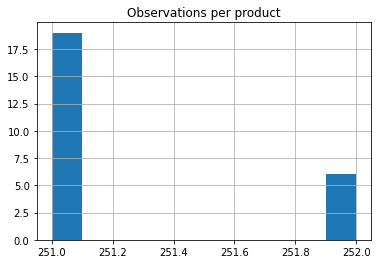

In [13]:
ax = products_stats_df['count'].hist()
_ = ax.set_title('Observations per product')

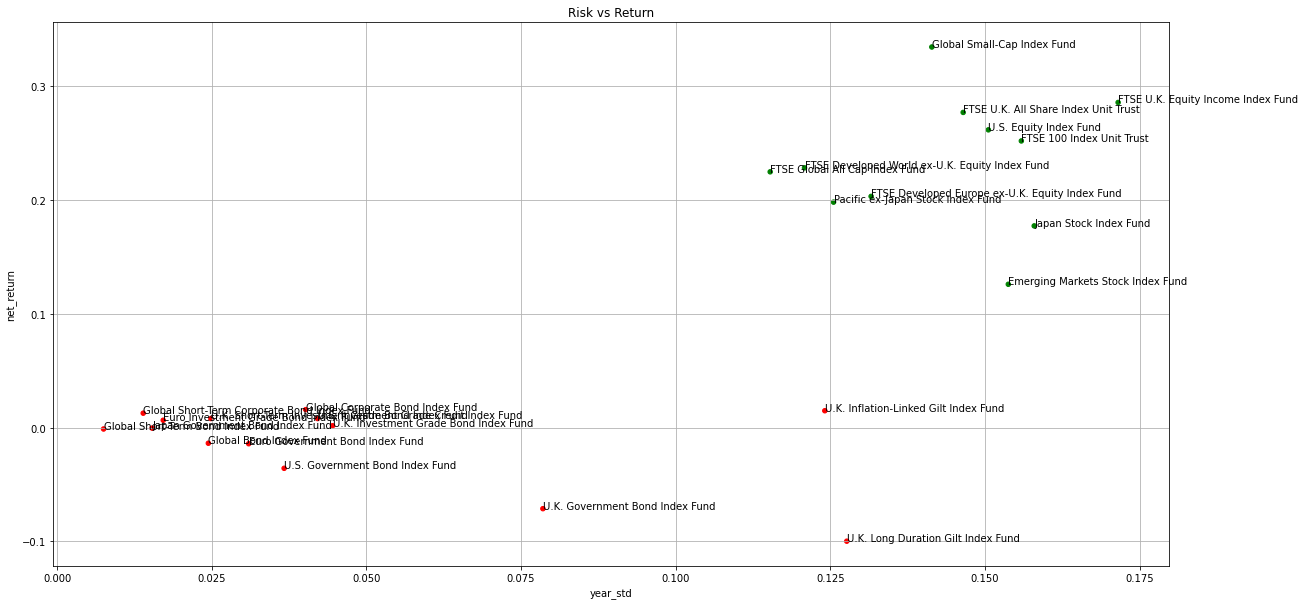

In [14]:
asset_colours = {
    "BOND": "red",
    "EQUITY": "green"
}

ax = (
    products_stats_df
    #.set_index('year_std')
    .plot.scatter(
        x='year_std',
        y='net_return',
        grid=True,
        figsize=(20, 10),
        c=products_stats_df['assetCode'].map(asset_colours)
    )
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(
    products_stats_df['year_std'], 
    products_stats_df['net_return'], 
    products_stats_df['name'], 
    ax
)
_ = ax.set_title("Risk vs Return")

## Prepare optimization Inputs

In [15]:
def pivot_returns(historical_df):
    return  (
        historical_df
        .pivot(index=['date'], columns=['sedol'], values=['day_return'])
        .droplevel(0, axis=1)
        .dropna(how='any')
    )


pivoted_returns = pivot_returns(historical_df)

In [16]:
def get_covariance(historical_df):

    return  (
        historical_df
        .pivot(index=['date'], columns=['sedol'], values=['day_return'])
        .droplevel(0, axis=1)
        .dropna(how='all')
        .cov()
        .sort_index()
        [lambda x: sorted(x.columns)]
    )
covariance = get_covariance(historical_df)

In [17]:
expected_returns = products_stats_df.set_index('sedol')['day_return_mean'].reindex(covariance.index)

## Optimization wrapper tool

In [18]:
class ProblemVariables:
    
    def __init__(self, expected_returns, covariance):
        
        assert (expected_returns.index == covariance.index).all()
        self.index = expected_returns.index
        er = expected_returns.to_numpy()
        cov = np.asmatrix(covariance.to_numpy())
        self.x = cp.Variable(len(expected_returns))
        self.vol = cp.quad_form(self.x, np.asmatrix(cov))
        self.ret = er.T @ self.x
        
    def results(self):
        return self.ret.value, self.std()
    
    def std(self):
        return np.sqrt(self.vol.value)
        
    
    def year_std(self):
        return self.std() * np.sqrt(253)
    
    def year_return(self):
        return (1 + self.ret.value)**253 - 1
    
    def full_results(self):
        results = dict(zip(self.index, self.x.value))
        results['return'] = self.year_return()
        results['std'] = self.year_std()
        return pd.Series(results)
    
    def maximize_returns(self):
        cp.Problem(cp.Maximize(self.ret), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self
        
    def minimize_std(self):
        cp.Problem(cp.Minimize(self.vol), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self

    def solve_for_std(self, std_limit):
        cp.Problem(
            cp.Maximize(self.ret),
              [
                  self.vol <= std_limit**2,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
        
    def iterate_stds(self, points):
        min_std = self.minimize_std().std()
        max_std = self.maximize_returns().std()
        
        std_values = np.linspace(min_std, max_std, points)
        results = []
        for std_limit in std_values:
            results.append(self.solve_for_std(std_limit).full_results())
        return pd.DataFrame(results)

    def solve_for_return(self, return_limit):
        prob = cp.Problem(
            cp.Minimize(self.vol),
              [
                  self.ret >= return_limit,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
    
    def iterate_returns(self, points):
        min_return = self.minimize_std().ret.value
        max_return = self.maximize_returns().ret.value
        
        return_values = np.linspace(min_return, max_return, points)
        
        results = []
        for return_value in return_values:
            results.append(self.solve_for_return(return_value).full_results())
        return pd.DataFrame(results)

returns_ptfs = ProblemVariables(expected_returns, covariance).minimize_std().iterate_returns(200)
std_ptfs = ProblemVariables(expected_returns, covariance).minimize_std().iterate_stds(200)

In [19]:
def renormalize(df):
    row_sum = df.sum(axis=1)
    return df.div(row_sum, axis=0)


def plot_ptfs(ptfs, products_df, key='std'):
    assert key in ('std', 'return')
    mapping = products_df.set_index('sedol')['name'].to_dict()

    return (
        ptfs
        .drop(columns=['return' if key == 'std' else 'std'])
        .set_index('std' if key == 'std' else 'return')
        #.drop(columns=['return'])
        .mask(lambda x: x < 0.01)
        .fillna(0)
        .loc[:, lambda x:(x != 0).any(axis=0)]
        .pipe(renormalize)
        .rename(columns=mapping)
        .plot
        .area(figsize=[20,10], grid=True, legend='reverse')
    )

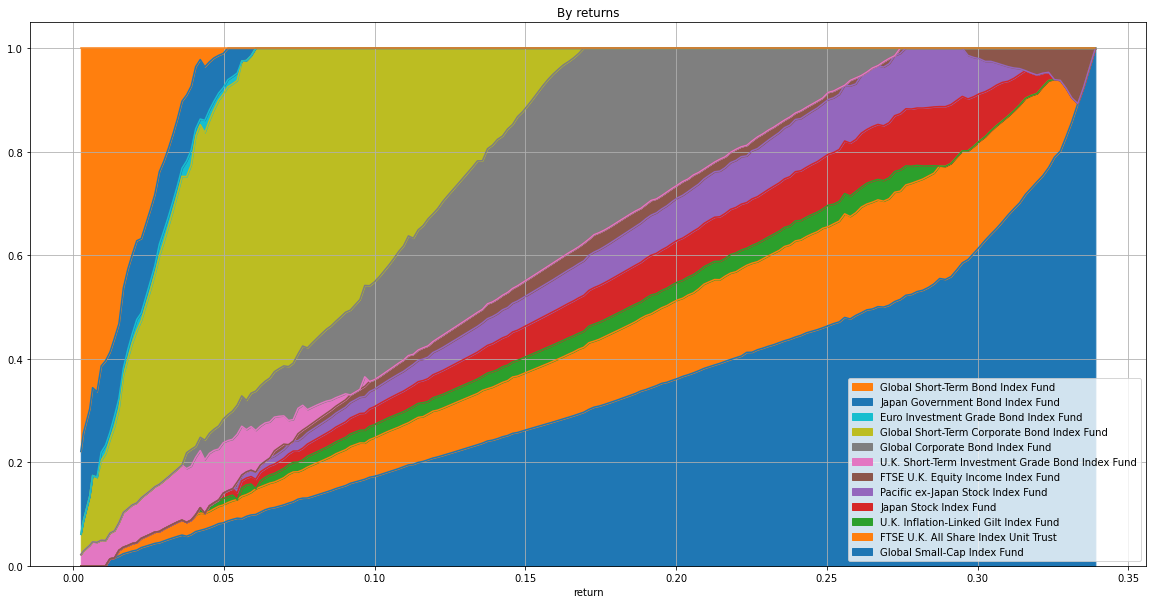

In [20]:
_ = plot_ptfs(returns_ptfs, products_df, key='return').set_title("By returns")

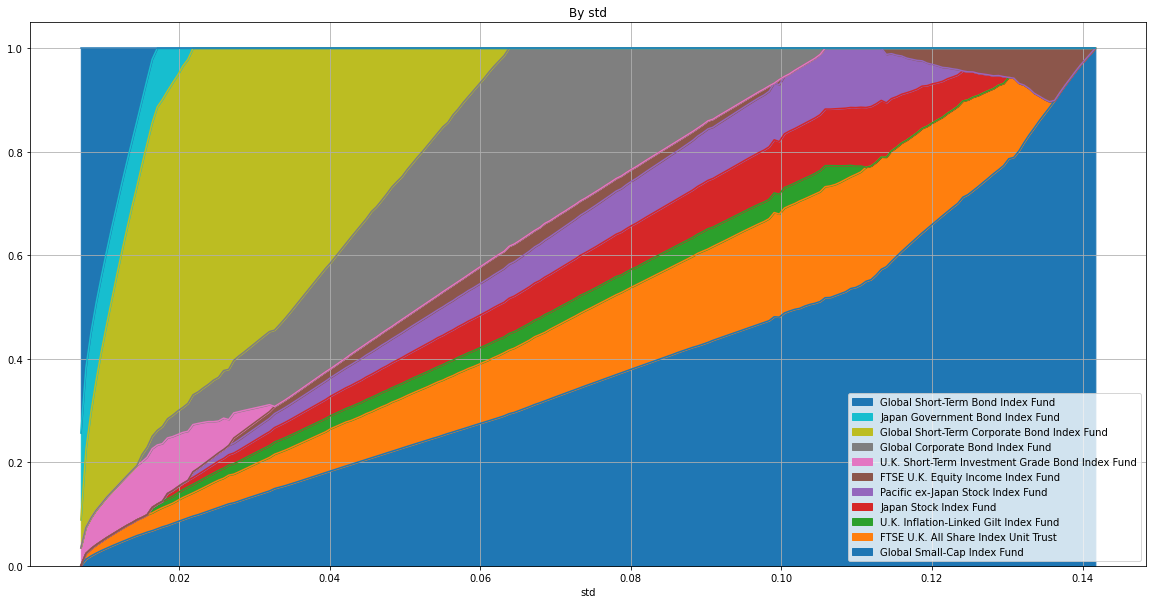

In [21]:
_ = plot_ptfs(std_ptfs, products_df, key='std').set_title("By std")

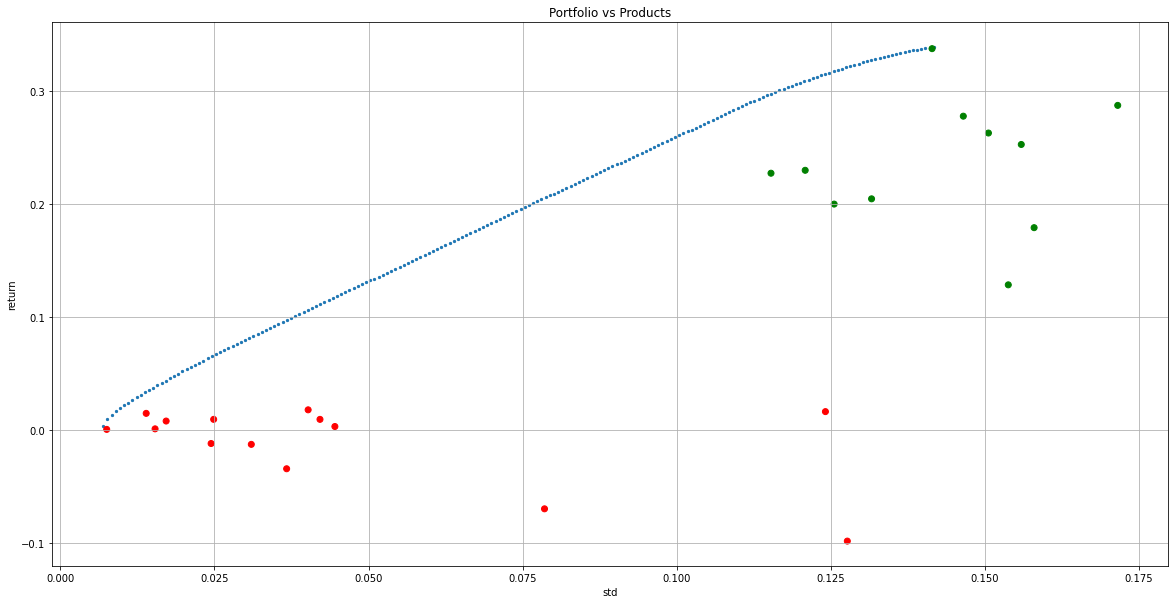

In [22]:
ax = (
    std_ptfs
    .plot.scatter(x='std', y='return', grid=True, marker='.', figsize=(20,10))
)
ax.scatter(
    x=products_stats_df['year_std'], 
    y=products_stats_df['year_return'],
    c=products_stats_df['assetCode'].map(asset_colours))
_ = ax.set_title('Portfolio vs Products')

# Appendix 2: Using a longer history

In [23]:
def get_chart(symbol):
    querystring = {
        "interval": '1d',
        "symbol": symbol, 
        "range": '10y',
        "region":"US",
    }

    headers = {
        'x-rapidapi-key': API_KEY,
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
    }

    response = requests.request("GET", GET_CHART_URL, headers=headers, params=querystring)
    if not response.from_cache:
        print("Not from cache " + symbol)
    return json.loads(response.text)

charts = {
    sedol: get_chart(symbol)
    for sedol, symbol in sedols_to_yahoo_symbol.items()
}


In [24]:
def chart_to_df(chart):
    return (
        pd.DataFrame(
            {
                "adjclose":chart['chart']['result'][0]['indicators']["adjclose"][0]['adjclose'],
                "timestamp":chart['chart']['result'][0]['timestamp']
            }
        ).assign(
            timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='s'),
            date=lambda x: x['timestamp'].dt.normalize(),
        )[lambda x: x['date'] != '2021-09-06']
        .assign(
            day_return=lambda x: (x['adjclose'] - x['adjclose'].shift()) /  x['adjclose'].shift(),
        )
    )
        

def charts_to_df(charts):
    dfs = [
        chart_to_df(chart).assign(sedol=sedol)
        for sedol, chart in charts.items()
    ]
    return pd.concat(dfs, ignore_index=True)


full_historical_df = charts_to_df(charts)

<AxesSubplot:>

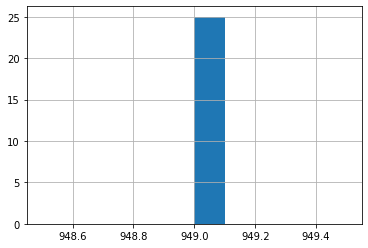

In [25]:
full_historical_df.groupby('sedol').size().rename('records').hist()

In [26]:
def get_yearly_returns(historical_df):

    pivotted = historical_df.pivot(index=['date'], columns=['sedol'], values=['day_return'])
    daily_returns = pivotted.mean().droplevel(0)
    return (((1 + daily_returns)**252) - 1).rename('yearly_returns')

full_expected_returns = full_historical_df.groupby('sedol')['day_return'].mean()
full_covariance = get_covariance(full_historical_df)

In [27]:
full_problem = ProblemVariables(full_expected_returns, full_covariance)

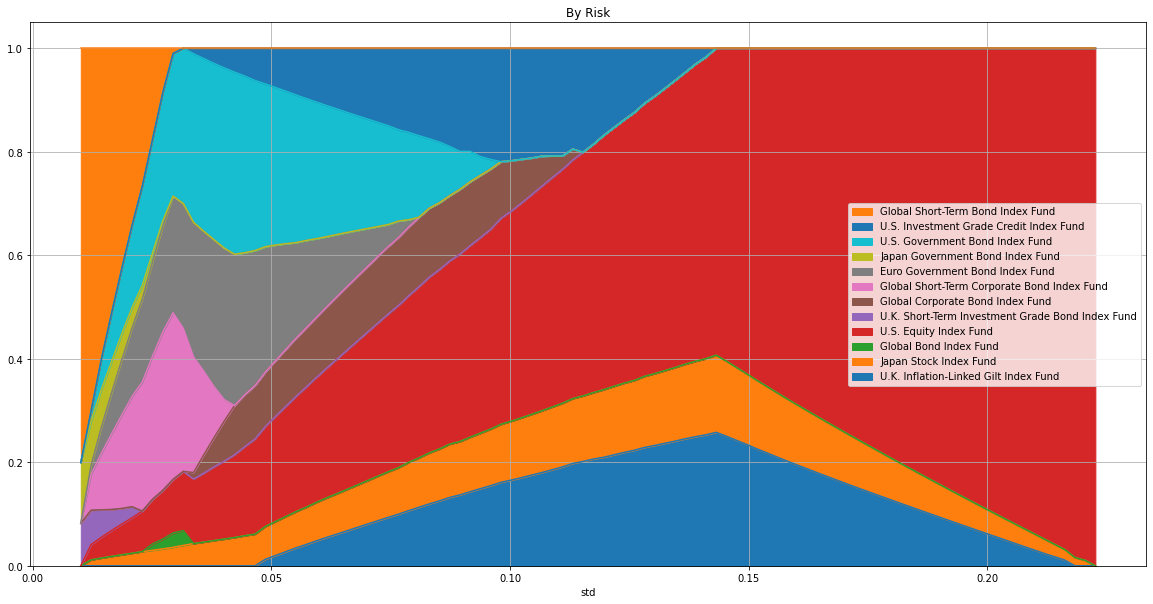

In [28]:
_ = (
    full_problem
    .iterate_stds(100)
    .pipe(plot_ptfs, products_df)
    .set_title("By Risk")
)

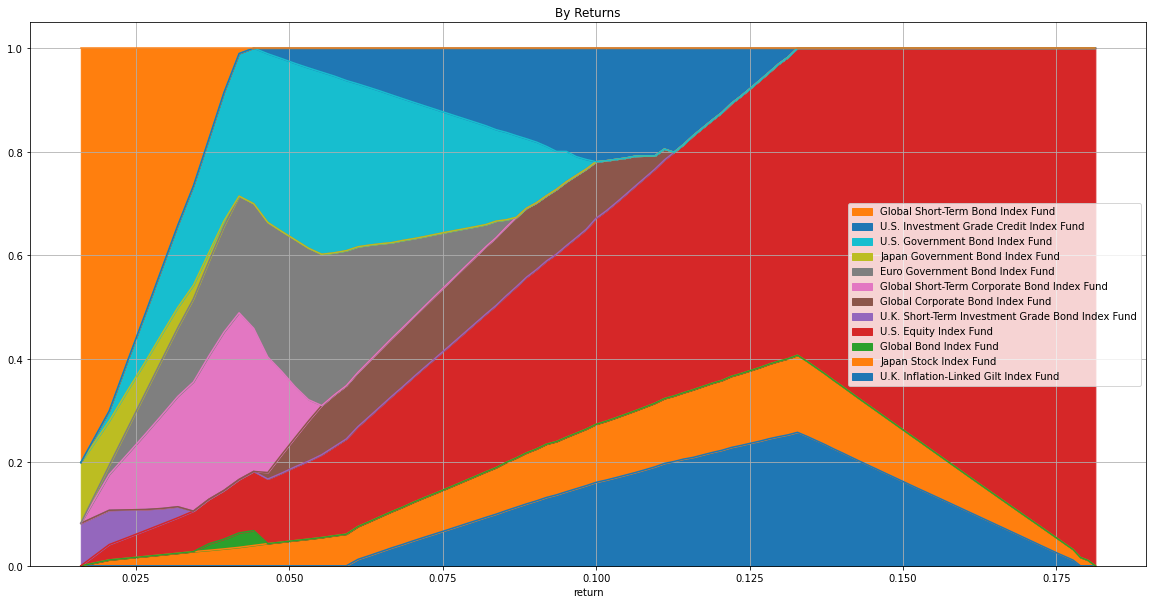

In [29]:
_ = (
    ProblemVariables(full_expected_returns, full_covariance)
    .iterate_stds(100)
    .pipe(plot_ptfs, products_df, "return")
    .set_title("By Returns")
)

# Appendix 2: identifying redundant products

In [30]:
absolute_vif = (
    pd.Series(
        [
            variance_inflation_factor(pivoted_returns.values, i)
            for i in range(len(pivoted_returns.columns))
        ],
        index=pivoted_returns.columns
    )
    .sort_values()
    .rename('vif')
    .to_frame()
    .join(products_df.set_index('sedol')[['name', 'managementType', 'extendedFundType' ]])
)

In [31]:
absolute_vif

,vif,name,managementType,extendedFundType
sedol,,,,
BFRTD94,1.327004,Japan Government Bond Index Fund,INDEX,mf
B9M1BB1,1.395645,U.K. Short-Term Investment Grade Bond Index Fund,INDEX,mf
BDFB763,1.991828,Global Short-Term Corporate Bond Index Fund,INDEX,mf
BH65QG5,2.254635,Global Short-Term Bond Index Fund,INDEX,mf
B45Q903,2.808733,U.K. Inflation-Linked Gilt Index Fund,INDEX,mf
BDFB5M5,3.361019,Global Corporate Bond Index Fund,INDEX,mf
BFRTDC7,4.173220,U.S. Investment Grade Credit Index Fund,INDEX,mf
B523L31,4.471919,Pacific ex-Japan Stock Index Fund,INDEX,mf
BFRTD83,4.515149,Euro Investment Grade Bond Index Fund,INDEX,mf


In [32]:
def calculate_vifs(pr):
    removed = {}
    for i in range(len(pr.columns) -1):
        vif = (
            pd.Series(
                [
                    variance_inflation_factor(pr.values, i)
                    for i in range(len(pr.columns))
                ],
                index=pr.columns
            )
            .sort_values()
            .rename('vif')
        )
        removed[vif.index[-1]] = vif.iloc[-1]
        
        pr = pr[lambda x: [c for c in x.columns if c not in removed]]
    removed[pr.columns[0]] = 1
    return pd.Series(removed, name='vif').sort_values()
                
recursive_vifs = (
    calculate_vifs(pivoted_returns)
    .to_frame()
    .join(products_df.set_index('sedol')[['name', 'managementType', 'extendedFundType', 'region', "assetCode" ]])
)
recursive_vifs

,vif,name,managementType,extendedFundType,region,assetCode
B59G4H8,1.000000,FTSE U.K. Equity Income Index Fund,INDEX,mf,UK,EQUITY
B9M1BB1,1.004114,U.K. Short-Term Investment Grade Bond Index Fund,INDEX,mf,UK,BOND
BFRTD94,1.012301,Japan Government Bond Index Fund,INDEX,mf,Japan,BOND
B50MZ94,1.033876,Japan Stock Index Fund,INDEX,mf,Japan,EQUITY
BDFB763,1.067468,Global Short-Term Corporate Bond Index Fund,INDEX,mf,Global,BOND
B5B71Q7,1.120693,U.S. Equity Index Fund,INDEX,mf,USA,EQUITY
B45Q903,1.170349,U.K. Inflation-Linked Gilt Index Fund,INDEX,mf,UK,BOND
BFRTDC7,1.357131,U.S. Investment Grade Credit Index Fund,INDEX,mf,USA,BOND
B50MZ72,1.526236,Emerging Markets Stock Index Fund,INDEX,mf,Emerging Markets,EQUITY
BFRTD83,1.737876,Euro Investment Grade Bond Index Fund,INDEX,mf,Europe,BOND


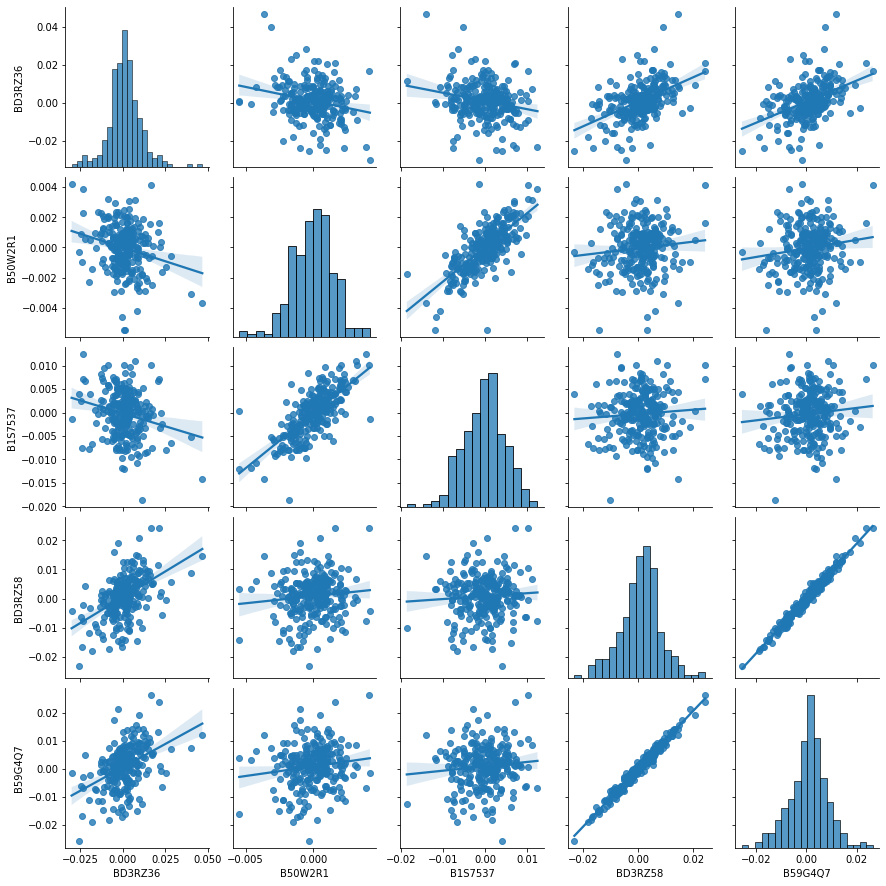

In [33]:
recursive_vifs.reset_index()
pg = sns.pairplot(pivoted_returns[recursive_vifs.index[-5:]], kind="reg")

In [34]:
full_pivoted_returns = pivot_returns(historical_df)
(
    calculate_vifs(full_pivoted_returns)
    .to_frame()
    .join(
        products_df.set_index('sedol')[[
            'name',
            'managementType',
            'extendedFundType', 
            'region',
            "assetCode" 
        ]]
    )
)

,vif,name,managementType,extendedFundType,region,assetCode
B59G4H8,1.000000,FTSE U.K. Equity Income Index Fund,INDEX,mf,UK,EQUITY
B9M1BB1,1.004114,U.K. Short-Term Investment Grade Bond Index Fund,INDEX,mf,UK,BOND
BFRTD94,1.012301,Japan Government Bond Index Fund,INDEX,mf,Japan,BOND
B50MZ94,1.033876,Japan Stock Index Fund,INDEX,mf,Japan,EQUITY
BDFB763,1.067468,Global Short-Term Corporate Bond Index Fund,INDEX,mf,Global,BOND
B5B71Q7,1.120693,U.S. Equity Index Fund,INDEX,mf,USA,EQUITY
B45Q903,1.170349,U.K. Inflation-Linked Gilt Index Fund,INDEX,mf,UK,BOND
BFRTDC7,1.357131,U.S. Investment Grade Credit Index Fund,INDEX,mf,USA,BOND
B50MZ72,1.526236,Emerging Markets Stock Index Fund,INDEX,mf,Emerging Markets,EQUITY
BFRTD83,1.737876,Euro Investment Grade Bond Index Fund,INDEX,mf,Europe,BOND
